# Analyze the Diversity PCA

In [152]:
import numpy as np
import os  # For Saving to Folder
import pandas as pd
import matplotlib.pyplot as plt

import socket
import os as os
import sys as sys
import multiprocessing as mp
import itertools as it
from time import time
from scipy.spatial.distance import pdist
from matplotlib import gridspec

# For Arial Font
from matplotlib import rcParams
rcParams['font.family'] = 'sans-serif'   # Set the defaul
rcParams['font.sans-serif'] = ['Arial']

socket_name = socket.gethostname()
print(socket_name)

if socket_name.startswith("compute-"):
    print("HSM Computational partition detected.")
    path = "/n/groups/reich/hringbauer/git/punic_aDNA/"  # The Path on Midway Cluster
else:
    raise RuntimeWarning("Not compatible machine. Check!!")

os.chdir(path)  # Set the right Path (in line with Atom default)
# Show the current working directory. Should be HAPSBURG/Notebooks/ParallelRuns
print(os.getcwd())
print(f"CPU Count: {mp.cpu_count()}")
print(sys.version)

compute-a-16-162.o2.rc.hms.harvard.edu
HSM Computational partition detected.
/n/groups/reich/hringbauer/git/punic_aDNA
CPU Count: 32
3.7.4 (default, Sep 11 2019, 11:24:51) 
[GCC 6.2.0]


In [153]:
min_snp = 20000
#path_pca = "./output/pca/v54.1var/20230424.varPCA.v54.1.construct_WE_NA_PCA.smYES.outitY.evec.txt"
path_pca = "./output/pca/v54.1var/20230425.varPCA.v54.1.construct_WE_NA_PCA.smYES.outitY.evec.txt"
path_meta = "/n/groups/reich/hringbauer/Data/v54.1.anno.csv"

savepath="" #"./output/pca/v54.1/pcs_meta.tsv"

df = pd.read_csv(path_pca, 
                 sep=r"\s+", skiprows=1, header=None)
df.columns=["iid", "pc1", "pc2", "pc3", "pc4", "pop"]
#df = remove_individuals(df, remove_list=["_d"])
df_meta = pd.read_csv(path_meta, sep=",")
df2 = df_meta[["iid", "Master ID", "loc", "n_cov_snp", 
               "mean_cov", "sex", "age", "contact", "clst", "region"]]
df = pd.merge(df, df2, on="iid", how="left")
df["clst"].fillna(inplace = True, value="missing") # Fill NaNs

idx = (df["n_cov_snp"]<min_snp)
df = df[~idx]
df.loc[df["loc"].isnull(), "loc"]="not assigned"
print(f"Filtered to {len(df)} Individuals based on Min SNP: {min_snp}")

df = df.sort_values(by="n_cov_snp", ascending=False)
dup = (df["Master ID"].duplicated() & ~df["Master ID"].isnull())
df = df[~dup].copy().reset_index(drop=True)
print(f"Filtered to {len(df)} based on duplicates")

idx = df["iid"]=="I22257" # The Sudan Outlier
df=df[~idx].copy().reset_index(drop=True)
print(f"Filtered to {len(df)} based on manual removals")
#df[df["pop"].str.contains("Lebanon")]

### Add Individuals from Punic project
df1 = pd.read_csv("./data/cluster_assignments_punic.v54.1c.tsv", sep="\t")
#iids_anc2 = df1["iid"].values
print(f"Extracted IIDs of {len(df1)} IIDs in Punic Project")
df_punic = pd.merge(df, df1, on="iid")
print(f"Merged to {len(df_punic)} Punic IIDs")

### Remove Romans
df_punic = df_punic[~df_punic["label"].str.contains("Roman")]
print(f"Filtered to {len(df_punic)} actually Punic Samples")

### Remove Punics from generat Meta
df = df[~df["iid"].isin(df1["iid"])]
df_anc = df[df["pop"]=="keep_anc"]
print(f"Filtered general Meta to {len(df_anc)} ancient, non Punic individuals")

Filtered to 3568 Individuals based on Min SNP: 20000
Filtered to 3568 based on duplicates
Filtered to 3568 based on manual removals
Extracted IIDs of 157 IIDs in Punic Project
Merged to 157 Punic IIDs
Filtered to 143 actually Punic Samples
Filtered general Meta to 2279 ancient, non Punic individuals


In [202]:
df_punic[df_punic["loc"].str.contains("Tharros")][["age", "date range"]]

,age,date range
27,2589.0,"767-519 calBCE (2480Â±20 BP, PSUAMS-9224)"
34,2582.0,"761-479 calBCE (2470Â±20 BP, PSUAMS-9808)"
38,2094.0,"340-53 calBCE (2125Â±20 BP, PSUAMS-8814)"
40,2225.0,"361-177 calBCE (2200Â±20 BP, PSUAMS-8838)"
44,2645.0,"796-551 calBCE (2545Â±25 BP, PSUAMS-9223)"
45,2614.0,"783-549 calBCE (2525Â±20 BP, PSUAMS-8813)"
53,2239.0,"387-208 calBCE (2245Â±20 BP, PSUAMS-9222)"
58,2131.0,"346-57 calBCE (2140Â±20 BP, PSUAMS-8837)"
65,2419.0,"541-402 calBCE (2400Â±20 BP, PSUAMS-9238)"
100,2239.0,"387-208 calBCE (2245Â±20 BP, PSUAMS-9208)"


# Plot PCA to check background

In [154]:
def plot_pca_ho(ax, df, c="gray", alpha=1.0, legend="", marker="o",
                s=30, ec=None, text=False):
    """Plot PCA onto Axis"""
    ax.scatter(-df["pc1"], df["pc2"], c=c, alpha=alpha, label=legend, 
               ec=ec, s=s, marker=marker)
    if text:
        x, y = -df["pc1"].values, df["pc2"].values
        for i, txt in enumerate(df["iid"]):
            ax.annotate(txt[:3], (x[i], y[i]), ha="center", va="center")  
            
def get_sub_pops_exact(df, pop_list=[], pop_col="pop"):
    """Get Sub Populations"""
    idx = df[pop_col].isin(pop_list)
    df = df[idx].copy()
    print(f"Found {pop_list} (exact): {len(df)}/{len(idx)}")
    return df

Found ['keep_ho'] (exact): 1132/3411


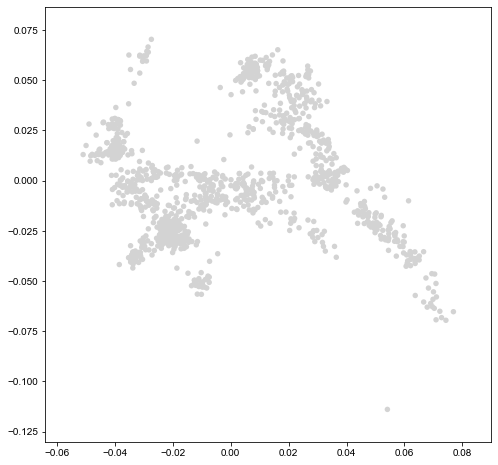

In [155]:
savepath=""

df_ho = get_sub_pops_exact(df, pop_list=["keep_ho"])
plt.figure(figsize=(8,8))
ax = plt.gca()
plot_pca_ho(ax, df_ho, c="lightgray", text=False)

if len(savepath) > 0:
    plt.savefig(savepath, bbox_inches = 'tight', 
                pad_inches = 0, dpi=600)
    print(f"Saved to: {savepath}")
    
plt.show()

In [91]:
df["pop"].value_counts()

keep_anc    2436
keep_ho     1132
Name: pop, dtype: int64

# Organize samples from each site

In [14]:
df_anc["loc"].value_counts()

Bohemia, Mikulovice                                            88
Murcia, Pliego, La Almoloya                                    66
Kamennyi Ambar 5 Cemetery                                      47
England, North Yorkshire, Vale of Pickering, West Heslerton    43
Roscommon, Kilteasheen                                         38
                                                               ..
Sicily, Marsala, Lilybaeum                                      1
Sicily, Marsala, Lilybaeum, via Berta                           1
Sicily, Palermo, Caserma Tukory                                 1
Cádiz, Solar Los Chinchorros                                    1
Cádiz, San Fernando, Campo de Hockey                            1
Name: loc, Length: 155, dtype: int64

In [156]:
def get_sub_df_region(df, region="", min_n=10, metric="mean_dist"):
    """Get a Dataframe of Y haplogroup diversities per sites"""
    df_reg = df[df["region"].isin(region)]
    cts = df_reg["loc"].value_counts()
    sites = cts[cts>=min_n].index.values
    
    df_res = create_pca_div_df(df, sites=sites, metric=metric)
    return df_res

def create_pca_div_df(df, sites=[], min_n=10, metric="mean_dist"):
    """Take Meta Data as input, and for each site calculates
    the Simpson Index of Y chromosomes"""
    data = []
    
    for s in sites:
        dft = df[df["loc"]==s] # Extract Site df 
        m = len(dft)
        if m==0:
            raise RuntimeWarning(f"Site {s} has no matching samples")
        age = np.median(dft["age"]) # Get the median Age
        
        if m >= min_n: # Calculate Variance
            if metric=="var":
                vars2 = np.var(dft[["pc1", "pc2"]], axis=0)
                var = np.sum(vars2)
                      
            elif metric=="mean_dist":
                ds = pdist(dft[["pc1", "pc2"]].values)
                var = np.mean(ds)
       
            else:
                raise RuntimeWarning(f"Metric {metric} not found!")
                
            data.append([s, age, m, var]) 
        else:
            continue
    
    # Make the summary Data Frame
    df_res = pd.DataFrame(data)
    df_res.columns = ["loc", "age", "n", "var"]
    return df_res

In [74]:
get_sub_df_region(df_anc, region=["Italy"])

,loc,age,n,var
0,"Piedmont, Collegno",1345.0,22,0.019920
1,Isola Sacra,1750.0,20,0.024799
2,"Lazio, Viterbo, Tarquinia",2151.0,17,0.009339
3,"Basilicata, Potenza, Venosa",1250.0,14,0.013856
4,"Sardinia, Tharros",2272.0,14,0.034455
5,"Sicily, Birgi",2473.5,12,0.019580
6,Villa Magna,595.0,12,0.014235
7,Tarquinia Monterozzi,2238.5,10,0.029262
8,"Tuscany, Grosseto, Casenovole",2350.0,10,0.007200


# Run the Diversity Plot

In [157]:
min_n = 10 # In Prep the Cutoff is at 10
df_it = get_sub_df_region(df, ["Italy"], min_n=min_n)
df_fr = get_sub_df_region(df_anc, ["France", "Germany", "Austria"], min_n=min_n)
df_ib = get_sub_df_region(df_anc, ["Spain", "Portugal"], min_n=min_n)
df_lev = get_sub_df_region(df_anc, ["Israel", "Lebanon"], min_n=min_n)
#df_y_ib = get_sub_df_region(["Spain", "Portugal"])

df_pun = create_pca_div_df(df_punic, sites=["Kerkouene", "Sardinia, Tharros",  "Sicily, Selinunte, Manuzza", "Sicily, Birgi", 
                                            'Almería, Cuevas del Almazora, Villaricos', "Tunis, Carthage",
                                            "Cap Bon, Kelibia"], min_n=7) # 
#df_y_him = create_pca_div_df(df_anc, sites=["Sicily, Himera"], min_n=5)

In [147]:
df_it.sort_values(by="var")

,loc,age,n,var
5,"Tuscany, Grosseto, Casenovole",2350.0,10,0.007200
2,"Lazio, Viterbo, Tarquinia",2151.0,17,0.009339
3,"Basilicata, Potenza, Venosa",1250.0,14,0.013856
4,Villa Magna,595.0,12,0.014235
0,"Piedmont, Collegno",1345.0,22,0.019920
1,Isola Sacra,1750.0,20,0.024799
6,Tarquinia Monterozzi,2238.5,10,0.029262


## 1)b) Plot PCA diversity

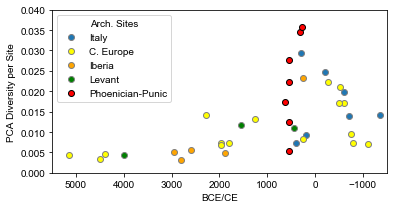

In [158]:
epsilon=0.0
xlim = [5500, -1500]

plt.figure(figsize=(6,3))
ax = plt.gca()
ax.scatter(df_it["age"]-1950, df_it["var"]+epsilon, ec="gray", label="Italy")
ax.scatter(df_fr["age"]-1950, df_fr["var"]+epsilon, c="yellow", ec="gray", label="C. Europe")
ax.scatter(df_ib["age"]-1950, df_ib["var"]+epsilon, c="orange", ec="gray", label="Iberia")
ax.scatter(df_lev["age"]-1950, df_lev["var"]+epsilon, c="green", ec="gray", label="Levant")
ax.scatter(df_pun["age"]-1950, df_pun["var"]+epsilon, ec="k", c="red", label="Phoenician-Punic")
#ax.scatter(df_y_him["age"]-1950, df_y_him["D"]+epsilon, ec="k", c="orange", label="Himera")

ax.set_ylabel("PCA Diversity per Site")
ax.set_xlabel("BCE/CE")
ax.invert_xaxis()
ax.legend(loc="upper left", title="Arch. Sites") # bbox_to_anchor=(1.02, 1.01)
#ax.set_yscale('squareroot')
ax.set_ylim([0,0.04])
ax.set_xlim(xlim)
plt.show()

In [ ]:
df_y_pun.sort_values(by="var")

In [ ]:
df_y_it.sort_values(by="var", ascending=False)

In [107]:
df_y_ib

,loc,age,n,var
0,"Murcia, Pliego, La Almoloya",3825.0,66,0.004878
1,"Burgos, Atapuerca, El Mirador Cave",4550.0,14,0.005530
2,"Barcelona, Cova de la Guineu",4900.0,10,0.005214
3,"Girona, Empuries, necropolis Centre de Visitants",2202.5,10,0.023326
4,"Alicante, Villena, Cueva de las Lechuzas",4750.0,10,0.003059
5,"Almería, Cuevas del Almazora, Villaricos",2046.5,10,0.039364


# 2) Plot PCA and Y Haplogroup Diversity in one Plot

### 2)a) Load the Y Results

In [138]:
df_y_it = pd.read_csv("./output/tables/ydiv/it.tsv", sep="\t")
df_y_fr = pd.read_csv("./output/tables/ydiv/fr.tsv", sep="\t")
df_y_ib = pd.read_csv("./output/tables/ydiv/ib.tsv", sep="\t")
df_y_lev = pd.read_csv("./output/tables/ydiv/lev.tsv", sep="\t")
df_y_pun = pd.read_csv("./output/tables/ydiv/pun.tsv", sep="\t")

# Make the big Plot for Paper

Saved to ./figures/div/panel.v54.1.png


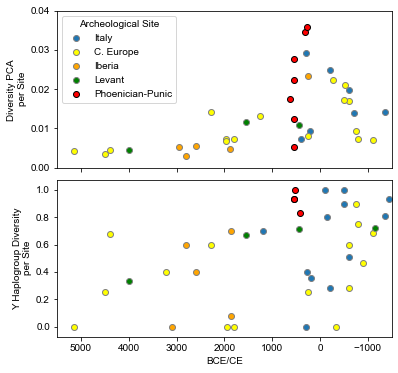

In [198]:
savepath="./figures/div/panel.v54.1.png"
figsize=(6,6)
hspace = 0.076
epsilon=0.0
xlim = [5500, -1500]


fig = plt.figure(figsize=figsize)

gs = gridspec.GridSpec(2, 1, height_ratios=[1,1], figure=fig)
ax_pca = plt.subplot(gs[0])    # The left subplot (Timeline)
ax_y =  plt.subplot(gs[1])
gs.update(hspace=hspace) # set the spacing between axes


ax_pca.scatter(df_it["age"]-1950, df_it["var"]+epsilon, ec="gray", label="Italy")
ax_pca.scatter(df_fr["age"]-1950, df_fr["var"]+epsilon, c="yellow", ec="gray", label="C. Europe")
ax_pca.scatter(df_ib["age"]-1950, df_ib["var"]+epsilon, c="orange", ec="gray", label="Iberia")
ax_pca.scatter(df_lev["age"]-1950, df_lev["var"]+epsilon, c="green", ec="gray", label="Levant")
ax_pca.scatter(df_pun["age"]-1950, df_pun["var"]+epsilon, ec="k", c="red", label="Phoenician-Punic")
ax_pca.legend(loc="upper left", title="Archeological Site") # bbox_to_anchor=(1.02, 1.01) $\bf{Archeological Sites}$
#ax.scatter(df_y_him["age"]-1950, df_y_him["D"]+epsilon, ec="k", c="orange", label="Himera")
ax_pca.set_ylabel("Diversity PCA \nper Site")
ax_pca.set_xlim(xlim)
#ax_pca.invert_xaxis()
ax_pca.set_ylim([0,0.04])
ax_pca.set_xticklabels([])

###########################
### Plot Y Diversity
ax_y.scatter(df_y_it["age"]-1950, df_y_it["D"]+epsilon, ec="gray", label="Italy")
ax_y.scatter(df_y_fr["age"]-1950, df_y_fr["D"]+epsilon, c="yellow", ec="gray", label="C. Europe")
ax_y.scatter(df_y_ib["age"]-1950, df_y_ib["D"]+epsilon, c="orange", ec="gray", label="Iberia")
ax_y.scatter(df_y_lev["age"]-1950, df_y_lev["D"]+epsilon, c="green", ec="gray", label="Levant")
ax_y.scatter(df_y_pun["age"]-1950, df_y_pun["D"]+epsilon, ec="k", c="red", label="Phoenician-Punic")
#ax.scatter(df_y_him["age"]-1950, df_y_him["D"]+epsilon, ec="k", c="orange", label="Himera")
ax_y.set_ylabel("Y Haplogroup Diversity\nper Site")
ax_y.set_xlabel("BCE/CE")
ax_y.set_xlim(xlim)
#ax_y.invert_xaxis()

#ax.set_yscale('squareroot')


if len(savepath)>0:
        plt.savefig(savepath, bbox_inches = 'tight', pad_inches = 0, dpi=600)
        print(f"Saved to {savepath}")

plt.show()

In [201]:
df_it.sort_values(by="var")

,loc,age,n,var
5,"Tuscany, Grosseto, Casenovole",2350.0,10,0.007200
2,"Lazio, Viterbo, Tarquinia",2151.0,17,0.009339
3,"Basilicata, Potenza, Venosa",1250.0,14,0.013856
4,Villa Magna,595.0,12,0.014235
0,"Piedmont, Collegno",1345.0,22,0.019920
1,Isola Sacra,1750.0,20,0.024799
6,Tarquinia Monterozzi,2238.5,10,0.029262


# Area 51

In [46]:
df_anc[df_anc["loc"].str.contains("Sicily, Selinunte, Manuzza")]["loc"].value_counts()

Sicily, Selinunte, Manuzza    7
Name: loc, dtype: int64

In [ ]:
df_anc[df_anc["loc"].str.contains("Sicily")]

In [ ]:
df_anc[df_anc["loc"].str.contains("Villaricos")]

In [38]:
df_punic = df_anc[df_anc["clst"].str.contains("Punic")]